This is the Julia 1.1.0 ED code of Kitaev model on a honeycomb lattice with rhomboid geometry. 

There are several aspects we should notice when writing Julia codes:

1. All indices start from $1$, a slice $i:j$ includes both $i$ and $j$.

2.

\section{Representation of spin-1/2 basis}

We use the eigen-states of $S^z$ as basis states and use $|0 \rangle$ to represent $|\downarrow \rangle$ and $|1 \rangle$ to represent $|\uparrow \rangle$. The states can thus be represented by a set of binary numbers. Moreover, we can use the corresponding dicimal number of each state as its tag.

For a system with N sites, the dimension of Hilbert space is $2^N$. The Hilbert space dimension can be furtuer reduced by applying symmetries and conservation laws.

The following code shows how to read the spin configuration of a dicimal tag. Note that we should use bits operation to reach maximun speed.

In [1]:
function bits(i::Integer, num::Integer)
    # Chenck the i-th element of the binary representation of a dicimal number
    # the bits count from right to left
    mask = 2^(i - 1)
    if num & mask == mask
        return 1
    else
        return 0
    end
end

bits (generic function with 1 method)

\section{Rhomboid $ N_1 \times N_2 \times 2$ lattice}

The lattice vectors are $\vec{n}_1 = (0,1), \vec{n}_2 = (\frac{1}{2},\frac{\sqrt{3}}{2})$. The number of unit cells along these two directions are $N_1$ and $N_2$ respectively. We label each unit cell by its row and colume numbers $(r, c)$(start from $0$), the label of this unit cell given by $ n = r \times N_1 + c$. We can label A atom in the $n$-th unit cell as $2(n+1) - 1$ and B atom as $2(n+1)$.

In [2]:
struct Lattice{T <: Integer}
    # Lattice size set up
    N1::T
    N2::T
end

struct Position{T <: Integer}
    # position of an atom in the lattice
    col::T
    row::T
    atom::T
end

dimension(la::Lattice) = 2^(la.N1 * la.N2 * 2)
sitenum(la::Lattice) = la.N1 * la.N2 * 2

function index(pos::Position, which::Int, la::Lattice)
    #= Calculate the index of the atoms in the (r,c) unit cell.
       c, l start from 0.
       A-sublattice atom = 0; B-subkattice: atom = 1. 
       which = 0, 1, 2, 3 corresponds to the original atom and 
        the one linked to it via x,y,z bonds =#
    
    which == 2 ? c = (pos.col -1)% la.N1 : c = pos.col% la.N1
    which == 3 ? r = (pos.row -1)% la.N2 : r = pos.row% la.N2
    which != 0 ? a = (pos.atom + 1)%2 : a = pos.atom
    
    c < 0 ? c += la.N1 : c += 0
    r < 0 ? r += la.N2 : r += 0
    n = r * la.N1 + c
    return 2*n +1 + a
end

function findposition(ind::Int, la::Lattice)
    #= find the position of ind in the lattice
       ind starts from 1 =#
    atom = (ind +1)%2 
    n = div((ind -1 -atom),2)
    r, c = divrem(n, la.N1)
    return Position(c, r, atom)
end

findposition (generic function with 1 method)

\section{Translational symmetry and Momentum basis}

\subsection{Translation operators}
\begin{align}
T_1^{N_1} = 1  &\Rightarrow k_1 = m_1 \frac{2 \pi}{N_1},\ m_1 = -N_1 //2 + 1 ,\dots, N_1//2 \\
T_2^{N_2} = 1  &\Rightarrow k_2 = m_2 \frac{2 \pi}{N_1},\ m_2 = -N_2 //2 + 1 ,\dots, N_2//2
\end{align}

\subsection{Monentum basis}

A momentum state can be constructed using a reference state $|a \rangle$ (a single state in z-component basis) and all its translations:
\begin{equation}
|a_{k_1,k_2} \rangle = \frac{1}{\sqrt{N_a}} 
                        \sum_{r_1 = 0}^{N_1-1} \sum_{r_2 = 0}^{N_2-1}
                          e^{-ik_1 r_1 - ik_2 r_2} T_1^{r_1} T_2^{r_2} |a \rangle
\end{equation}

We can easily prove that:
\begin{equation}
T_j |a_{k_1,k_2} \rangle = e^{-ik_j} |a_{k_1,k_2} \rangle, \ j = 1,2
\end{equation}

To construct a complete set of normalizable orthogonal state for a given $\vec{k} = (k_1, k_2)$, the corresponding representatives must obey:

\begin{equation}
T^{\vec{r}}|a \rangle = T_1^{r_1} T_2^{r_2} |a \rangle \neq |b \rangle, 
\quad r_{1,2} = 0,\dots,N_{1,2}-1 
\end{equation}

We can use only one of the states that related by translation operations as the reference state, normally we choose the one with the smallest index.

That is to find the generating set $S$ of the translation group $G$ of the lattice and its factor group $G/S$. Here is how.

Suppose we have a staring state $si$, then we apply the translation operators one by one to it. Everytime we find a new state, the operation belongs to $S$, and everytime it comes back to the initial state $si$, the operation belongs to $G/S$. Then the momentum state can be written as:

\begin{equation}
|a_{k_1,k_2} \rangle = \frac{1}{\sqrt{N_a}} 
                        \sum_{T^{\vec{r}} \in S}
                          e^{-i \vec{k} \cdot \vec{r} } T^{\vec{r}} |a \rangle
\end{equation}

where:
\begin{equation}
\frac{1}{\sqrt{N_a}} = \frac{n_a}{\sqrt{N}} \sum_{T^{\vec{r}'} \in G/S} T^{\vec{r}'}
\end{equation}

where $N = N_1 \times N_2$ and $n_a$ is the total number of elements in $S$.

The dimension of the Hilbert space is approximately reduced by $N$ times, $D \approx 2^{2N} /N$.

In [3]:
struct SymmetricBasis{T1 <: Integer, T2 <: AbstractFloat}
    bs::Array{T1,1} # basis state
    rs::Array{T1,1} # reference state
    na::Array{T2,1} # renormalization factor
    θre::Array{T2,1} # real part of the phase 
    θim::Array{T2,1} # imaginary part of the phase
end

function cyclebits(n1::Int, n2::Int, tag::Int, la::Lattice)
    #=Performs a cyclic permutations of n1 steps to the right and n2 steps upward.
       Inputs: tag: tag of the reference state
               n1: cycle times of n1-direction, columns,if n1=0, no cycle in columns
               n2: cycle times of n2-direction, rows,if n2=0, no cycle in rows
               N1: number of columns
               N2: number of rows
       Outputs: ntag: the tag of the outcoming state=#
    num = sitenum(la)
    ntag = 0
    for r = 0: la.N2-1, c = 0: la.N1 -1, atom = 0: 1
        ind = index(Position(c,r,atom), 0, la)
        nind = index(Position(c+n1,r+n2,atom), 0, la) # n1: ->right, n2 -> up
        ntag += 2^(nind - 1) * bits(ind, tag)
    end
    return ntag
end

function MomBasis(k1::Int, k2::Int, la::Lattice)
    #Momentum basis list of a given k1, k2
    dim = dimension(la)
    bs = [x for x = 1: dim] # momentum basis
    rs, na = zeros(Int, dim), -ones(dim)
    θre, θim = zeros(Float64, dim), zeros(Float64, dim)
    
    error = 1.e-8
    
    k1, k2 = 2* pi/la.N1 * k1, 2* pi/la.N2 * k2
    
    for tag = 0: (dim - 1)
        count = 0 # count number of non-equicalent translation operations
        fac = 0.0im # accumulate renormalization factor
        if na[tag + 1] < 0
            for n1 = 0: la.N1-1, n2 = 0: la.N2-1
                ntag = cyclebits(n1, n2, tag, la)
                rs[ntag + 1] = tag
                # note the first translation operation that obtains this state
                if na[ntag + 1] < 0
                    θre[ntag + 1] = cos(n1* k1 + n2* k2)
                    θim[ntag + 1] = sin(n1* k1 + n2* k2)
                end
                
                if ntag > tag
                    na[ntag + 1] = 0
                elseif ntag == tag
                    fac += exp(-1im*k1*n1 - 1im*k2*n2)
                    count += 1
                    na[ntag + 1] = 1
                end
            end
            
            if abs(fac) < error
                fac = 0
            end
            na[tag + 1] *= abs(fac)* sqrt(la.N1 * la.N2 /count)
        end
    end
    
    for i = 1: dim
        bs[i] = bs[i] * sign(na[i])
    end 
    
    na = filter!(x->x != 0, na)
    bs = filter!(x->x != 0, bs)
    bs = replace!(x -> x-1, bs)
    return SymmetricBasis(bs, rs, na, θre, θim)                     
end

MomBasis (generic function with 1 method)

\subsection{Hamiltonian matrix elements}

If we have a hamiltonian:

\begin{equation}
H = \sum_j h_j
\end{equation}

and apply the $j$-th term to a momentum state $|a(\vec{k}) \rangle$:

\begin{align}
\begin{split}
h_j |a(\vec{k}) \rangle &= h_j \frac{1}{\sqrt{N_a}} \sum_{T^\vec{r} \in S}
                          e^{-i \vec{k} \cdot \vec{r} } T^\vec{r} |a \rangle \\
                        &= \frac{1}{\sqrt{N_a}} \sum_{T^\vec{r} \in S}
                          e^{-i \vec{k} \cdot \vec{r} } T^\vec{r} h_j |a \rangle \\
                        &= \frac{h_j(a)}{\sqrt{N_a}} \sum_{T^\vec{r} \in S}
                          e^{-i \vec{k} \cdot \vec{r} } T^\vec{r} |b' \rangle \\
\end{split}
\end{align}

where $|b' \rangle$ is the new state obtained after applying $h_j$, note that the prime means that $|b' \rangle$ may not be a reference state in our momentum basis. Suppose $|b' \rangle$ relates with its reference state $|b \rangle$ via:

\begin{equation}
T^\vec{l} |b' \rangle = |b \rangle
\end{equation}

Then we have:
\begin{align}
\begin{split}
h_j |a(\vec{k}) \rangle &= \frac{h_j(a)}{\sqrt{N_a}} \sum_{T^\vec{r} \in S}
                          e^{-i \vec{k} \cdot \vec{r} } T^\vec{r} |b' \rangle \\
                 &= \frac{h_j(a)}{\sqrt{N_a}} \sum_{T^\vec{r} \in S}
                    e^{-i \vec{k} \cdot \vec{r} } T^\vec{r} T^{-\vec{l}}|b \rangle \\          &= \frac{h_j(a)}{\sqrt{N_a}} e^{-i\vec{k} \cdot \vec{l}} \sum_{T^\vec{r} \in S}
            e^{-i \vec{k} \cdot (\vec{r} - \vec{l})} T^{\vec{r} -\vec{l}}|b \rangle \\
     &= \frac{h_j(a)}{\sqrt{N_a}} e^{-i\vec{k} \cdot \vec{l}} \sum_{T^{\vec{r}'} \in S}
            e^{-i \vec{k} \cdot \vec{r}'} T^{\vec{r}'}|b \rangle \\
     &= h_j(a) \sqrt{\frac{N_b}{N_a}} e^{-i\vec{k} \cdot \vec{l}} |b(\vec{k}) \rangle \\
\end{split}
\end{align}

Therefore, the matrix element

\begin{equation}
\langle b(\vec{k})| h_j |a(\vec{k}) \rangle
     = h_j(a) \sqrt{\frac{N_b}{N_a}} e^{-i\vec{k} \cdot \vec{l}}
\end{equation}

\section{Model Hamiltonian}
\subsection{Kitaev Hamiltonian}

\begin{equation}
    H_K = - \sum_{<j,k>_\alpha} K_\alpha S_j^\alpha S_k^\alpha
\end{equation}
where $\alpha = x, y, z$.


The Hamiltonian can be rewriten to $H_K = H_x + H_y +H_z$, where $H_z$ is the diagonal term and $H_x, H_y$ are off-diagonal terms:

\begin{align}
      H_x &= -\sum_{<i,j>_x} K_x S_i^x S_j^x = -\sum_{<i,j>_x} \frac{K_x}{4} ( S_i^+ S_j^- + S_i^- S_j^+ + S_i^+ S_j^+            + S_i^- S_j^-)\\
      H_y &= -\sum_{<i,j>_y} K_y S_i^y S_j^y = -\sum_{<i,j>_y} \frac{K_y}{4} ( S_i^+ S_j^- + S_i^- S_j^+ - S_i^+ S_j^+            - S_i^- S_j^-)\\
      H_z &= -\sum_{<i,j>_z} K_z S_i^z S_j^z
\end{align}
where $S_i^\pm = S_i^x \pm i S_i^y$.


For reference, the ground state energies of Kitaev model with different lattice sizes are (PBC):

| N1 | N2 | GS energy |
|---|---|---|
|2  | 3 | -0.204172555  |
|2  | 4 | -0.2022542475 |
|3  | 3 | -0.19849309   |
|3  | 4 | -0.198872775  |
|2  | 6 | -0.2003512    |

In [104]:
function flip(i::Int, j::Int, tag::Int)
    #=Flip the spin on i,j site.
    Inputs: tag: tag of a state
            i,j: position of spins that are flipped
    Output: The tag of new state, type: int =#
    mask = 2^(i-1) + 2^(j-1)
    return xor(tag, mask)
end

function append_data(j::Int, colptr::Int, count::Int, row::Array{Int,1})
    point = colptr - 1
    for pos = colptr: count
        point += 1
        if row[pos] == j
            return pos, count
            break
        end
    end
            
    if point == count
        return count, count+1
    end
end

function apply_Kitaev(ind::Int, bond::Int, si::Int, K::Array{Float64,1}, la::Lattice)
    # apply the ind-th Kitaev term on bond to si state
    pos = findposition(ind, la)
    nind = index(pos, bond, la)
    val = 0.0
    if bond == 1
        sf = flip(ind, nind, si)
        val = -K[1] /4
    elseif bond == 2
        sf = flip(ind, nind, si)
        val = K[2] * (bits(ind, si) - 0.5) * (bits(nind, si) - 0.5)
    elseif bond == 3
        sf = si
        val = - K[3] * (bits(ind, si) - 0.5) * (bits(nind, si) - 0.5)
    end
    return sf, val
end

function Kitaev(K::Array{Float64,1}, la::Lattice)
    dim = dimension(la)
    num = sitenum(la)
    max = dim * (num + 1)
    error = 1.e-8
    
    col, row, data = zeros(Int, dim+1), zeros(Int, max), zeros(max)
    colptr, count = 1, 1
    
    for si = 0: (dim-1)
        col[si+1] = colptr
        for ind = 1:2:num, bond = 1:3
            sf, val = apply_Kitaev(ind, bond, si, K, la)
            if abs(val) > error
                pos, count = append_data(sf + 1, colptr, count, row)
                row[pos] = sf + 1
                data[pos] += val
            end
        end
        colptr = count
    end
    col[dim + 1] = count
    return SparseMatrixCSC(dim, dim, col, row[1:count-1], data[1:count-1])
end

Kitaev (generic function with 1 method)

In [6]:
using SparseArrays
using Arpack
using BenchmarkTools

function findindex(tag::Int, mb::Array{Int,1})
    # find the index of tag in a sorted mb
    dim = length(mb)
    ind = searchsortedfirst(mb, tag)
    if ind <= dim
        if mb[ind] == tag
            return ind
        end
    else
        return -1
    end
    return -1
end

function Kitaev_T(K::Array{Float64,1}, k1::Int, k2::Int, mb::SymmetricBasis, la::Lattice)
    dim = length(mb.bs)
    num = sitenum(la)
    max = dim * (num + 1)
    error = 1.e-8
    
    col, row = zeros(Int, dim+1), zeros(Int, max)
    data_re, data_im = zeros(max), zeros(max)
    colptr, count = 1, 1
    
    for i = 1: dim
        si = mb.bs[i]
        col[i] = colptr
        for ind = 1:2:num, bond = 1:3
            sf, val = apply_Kitaev(ind, bond, si, K, la)
            
            ref = mb.rs[sf+1]
            j = findindex(ref, mb.bs)
            if (j > 0) & (abs(val) > error)
                val_re = val * mb.na[j]/mb.na[i] * mb.θre[sf+1]
                val_im = val * mb.na[j]/mb.na[i] * mb.θim[sf+1]
            
                if abs(val_re + 1im * val_im) > error
                    pos, count = append_data(j, colptr, count, row)
                    row[pos] = j
                    data_re[pos] += val_re
                    data_im[pos] += val_im
                end
            end
        end
        colptr = count
    end
    col[dim+1] = count
    data = data_re[1:count-1] + 1im* data_im[1:count-1]
    return SparseMatrixCSC(dim, dim, col, row[1:count-1], data)
end 

Kitaev_T (generic function with 1 method)

\subsection{Magnetic field Hamiltonian}

The magnetic field Hamiltonian is:

\begin{equation}
    H_h = - \sum_j \vec{h} \cdot \vec{S_j} = - \sum_{j,\alpha} h_\alpha S_j^\alpha, \ \ \alpha= x, y, z
\end{equation}

Using the relations:
\begin{align}
    S_j^x & = \frac{1}{2}( S_j^- + S_j^+ )\\
    S_j^y & = - \frac{i}{2} (S_j^+ - S_j^- )
\end{align}

In [135]:
function flip1(i::Integer, tag::Integer)
    mask = 2^(i-1)
    return xor(tag, mask)
end

function apply_h(ind::Int, isz::Int, si::Int, h::Array{Float64,1})
    val = 0.0im
    if isz == 0
        sf = flip1(ind, si)
        val = -h[1]/2 - 1im * h[2] * (bits(ind, si) - 0.5)
    else
        sf = si
        val = -h[3] * (bits(ind, si) - 0.5)
    end
    return sf, val      
end

function hfield(h::Array{Float64,1}, la::Lattice)
    dim = dimension(la)
    num = sitenum(la)
    max = dim * num * 2
    error = 1.e-8
    
    col, row = zeros(Int, dim+1), zeros(Int, max)
    data_re, data_im = zeros(max), zeros(max)
    colptr, count = 1, 1
    
    for si = 0: (dim-1)
        col[si+1] = colptr
        for ind = 1:num, isz = 0:1
            sf, val = apply_h(ind, isz, si, h)
            if abs(val) > error
                pos, count = append_data(sf + 1, colptr, count, row)
                row[pos] = sf + 1
                data_re[pos] += real(val)
                data_im[pos] += imag(val)
            end
        end
        colptr = count
    end
    col[dim + 1] = count
    data = data_re[1: count-1] + 1im * data_im[1: count-1]
    return SparseMatrixCSC(dim, dim, col, row[1:count-1], data)
end

function hfield_T(h::Array{Float64,1}, k1::Int, k2::Int, mb::SymmetricBasis, la::Lattice)
    dim = length(mb.bs)
    num = sitenum(la)
    max = dim * num * 2
    error = 1.e-8
    
    col, row = zeros(Int, dim+1), zeros(Int, max)
    data_re, data_im = zeros(max), zeros(max)
    colptr, count = 1, 1
    
    for i = 1: dim
        si = mb.bs[i]
        col[i] = colptr
        for ind = 1:num, isz = 0:1
            sf, val = apply_h(ind, isz, si, h)
            ref = mb.rs[sf+1]
            j = findindex(ref, mb.bs)
            if (j > 0) & (abs(val) > error)
                θ = mb.θre[sf + 1] + 1im * mb.θim[sf + 1]
                val_re = real(val * θ) * mb.na[j]/mb.na[i]
                val_im = imag(val * θ) * mb.na[j]/mb.na[i]
            
                if abs(val_re + 1im * val_im) > error
                    pos, count = append_data(j, colptr, count, row)
                    row[pos] = j
                    data_re[pos] += val_re
                    data_im[pos] += val_im
                end
            end
        end
        colptr = count
    end
    col[dim+1] = count
    data = data_re[1:count-1] + 1im* data_im[1:count-1]
    return SparseMatrixCSC(dim, dim, col, row[1:count-1], data)
end

function magnetization(axis::Int, state::Array{<:Number,1}, mb::SymmetricBasis, la::Lattice)
    dim = length(mb.bs)
    num = sitenum(la)
    m = 0.0
    error =1.e-8
    
    for i = 1:dim
        si = mb.bs[i]
        for ind = 1: num
            axis == 3 ? sf = si : sf = flip1(ind, si)
            ref = mb.rs[sf + 1]
            j = findindex(ref, mb.bs)
            if j > 0
                θ = mb.θre[sf + 1] + 1im * mb.θim[sf + 1]
                fac = θ * mb.na[j]/mb.na[i] * conj(state[j]) * state[i]
                if axis == 1
                    m += 1/2 * fac
                elseif axis == 2
                    m += 1im * (bits(ind,si) -0.5)* fac
                elseif axis == 3
                    m += (bits(ind,si) -0.5)* fac
                end
            end
        end
    end
    (abs(imag(m)) < error) ? m = real(m) : m = m
    return m/num
end

magnetization (generic function with 1 method)

In [155]:
"""test code"""
la = Lattice(2,3)
num = sitenum(la)

K = -[1.0, 1.0, 1.0]

hmin = 0.0
hmax = 0.5
step = 0.0125
total = convert(Int,(hmax - hmin)/step + 1)

evt = zeros(total,6)
count = 0    
    
for i = hmin:step:hmax
    count += 1
    h = i * ones(3)
    
    ek = zeros(num*3)
    countk = 0
    for k1 = -div(la.N1,2)+1: div(la.N1,2), k2 = -div(la.N2,2)+1: div(la.N2,2)
        mb = MomBasis(k1, k2, la)
        Hk = Kitaev_T(K, k1, k2, mb, la)
        Hh = hfield_T(h, k1, k2, mb, la)
        H = Hk + Hh
        e, x = eigs(H, which = :SR)
        for k = 1:6
            ek[countk + k] = real(e[k])
        end
        countk += 6
    end
    
    ek = sort(ek)
    for j = 1:6
        evt[count, j] = ek[j]/num
    end
end
println("Finish!")

Finish!


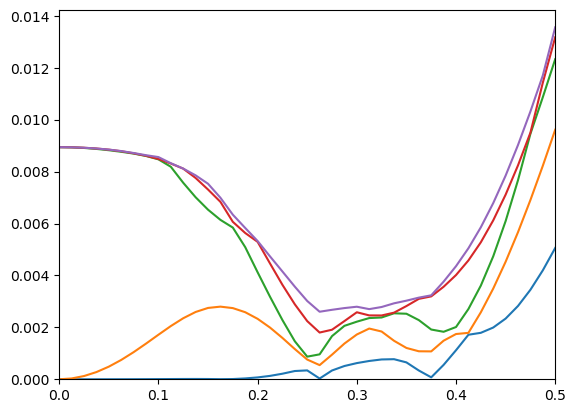

(0, 0.014237214124200311)

In [161]:
using PyPlot
#plot(hmin:step:hmax, ev[:, 1])
plot(hmin:step:hmax, evt[:,2] - evt[:, 1])
plot(hmin:step:hmax, evt[:,3] - evt[:, 1])
plot(hmin:step:hmax, evt[:,4] - evt[:, 1])
plot(hmin:step:hmax, evt[:,5] - evt[:, 1])
plot(hmin:step:hmax, evt[:,6] - evt[:, 1])
xlim(0,0.5)
ylim(0, )

In [162]:
"""test code without symmetry"""
la = Lattice(3,3)
num = sitenum(la)

K = -[1.0, 1.0, 1.0]

hmin = 0.0
hmax = 0.5
step = 0.0125
total = convert(Int,(hmax - hmin)/step + 1)

ev = zeros(total,6)
count = 0    

Hk = Kitaev(K, la)
for i = hmin:step:hmax
    count += 1
    h = i * ones(3)
    Hh = hfield(h, la)
    H = Hk + Hh
    e,x = eigs(H, which = :SR)
    for j = 1:6
        ev[count, j] = real(e[j])/num
    end
end
println("Finish!")

Finish!


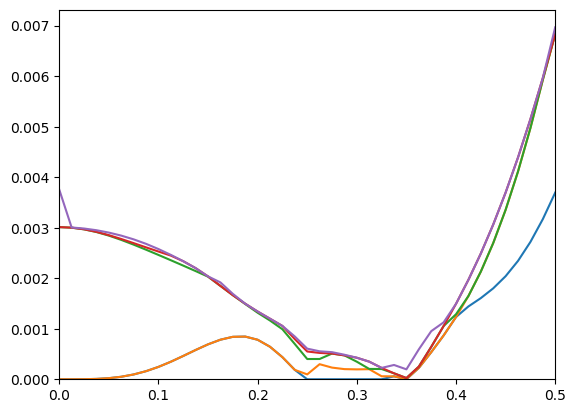

(0, 0.0073162064584854775)

In [163]:
using PyPlot
#plot(hmin:step:hmax, ev[:, 1])
plot(hmin:step:hmax, ev[:,2] - ev[:, 1])
plot(hmin:step:hmax, ev[:,3] - ev[:, 1])
plot(hmin:step:hmax, ev[:,4] - ev[:, 1])
plot(hmin:step:hmax, ev[:,5] - ev[:, 1])
plot(hmin:step:hmax, ev[:,6] - ev[:, 1])
xlim(0,0.5)
ylim(0, )

\subsection{Heisenberg Hamiltonian}
\begin{equation}
    H_J = \sum_{(j,k), \alpha} J_\alpha \vec{S}_j \cdot \vec{S}_k
\end{equation}
where $\alpha = x, y, z$.

\begin{align}
    S_i^x S_j^x &= \frac{1}{4} ( S_i^+ S_j^- + S_i^- S_j^+ + S_i^+ S_j^+ + S_i^- S_j^-)\\
    S_i^y S_j^y &= \frac{1}{4} ( S_i^+ S_j^- + S_i^- S_j^+ - S_i^+ S_j^+ - S_i^- S_j^-)\\
\end{align}
where $S_i^\pm = S_i^x \pm i S_i^y$.

Here we consider XXZ model, i.e. $J_x = J_y = J_{xy}$. Then the Hamiltonian becomes:

\begin{equation}
    H_J = \sum_{(j,k), \alpha} [J_z S_j^z S_k^z + \frac{J_{xy}}{2} (S_i^+ S_j^- + S_i^- S_j^+)]
\end{equation}

In [4]:
function apply_J(ind::Int, bond::Int, isz::Int, si::Int, J::Array{Float64,1}, la::Lattice)
    # Nearest neighbor Heisenberg Hamiltonian
    pos = findposition(ind, la)
    nind = index(pos, bond, la)
    val = 0.0
    if isz == 1
        sf = si
        val = J[3] * (bits(ind, si) - 0.5) * (bits(nind, si) - 0.5)
    else
        sf = flip(ind, nind, si)
        val = J[1] /4 - J[2] * (bits(ind, si) - 0.5) * (bits(nind, si) - 0.5)
    end
    return sf, val
end

apply_J (generic function with 1 method)

In [7]:
function Heisenberg_J(J::Array{Float64,1}, k1::Int, k2::Int, mb::SymmetricBasis, la::Lattice)
    dim = length(mb.bs)
    num = sitenum(la)
    max = dim * num * 2
    error = 1.e-8
    
    col, row = zeros(Int, dim+1), zeros(Int, max)
    data_re, data_im = zeros(max), zeros(max)
    colptr, count = 1, 1
    
    for i = 1: dim
        si = mb.bs[i]
        col[i] = colptr
        for ind = 1:num, bond = 1:3, isz = 0:1
            sf, val = apply_J(ind, bond, isz, si, J, la)
            ref = mb.rs[sf+1]
            j = findindex(ref, mb.bs)
            if (j > 0) & (abs(val) > error)
                val_re = val * mb.na[j]/mb.na[i] * mb.θre[sf + 1]
                val_im = val * mb.na[j]/mb.na[i] * mb.θim[sf + 1]
            
                if abs(val_re + 1im * val_im) > error
                    pos, count = append_data(j, colptr, count, row)
                    row[pos] = j
                    data_re[pos] += val_re
                    data_im[pos] += val_im
                end
            end
        end
        colptr = count
    end
    col[dim+1] = count
    data = data_re[1:count-1] + 1im* data_im[1:count-1]
    return SparseMatrixCSC(dim, dim, col, row[1:count-1], data)
end

Heisenberg_J (generic function with 1 method)

5

In [66]:
"""test add CSC matrix"""
col1 = [1,2,3,4]
row1 = [1,2,3]
val1 = [1,2,3]

a1 = SparseMatrixCSC(3, 3, col1, row1, val1)

col2 = [1,2,4,5]
row2 =[1,2,3,3]
val2 =[1,2,3,4]
a2 = SparseMatrixCSC(3, 3, col2, row2, val2)

3×3 SparseMatrixCSC{Int64,Int64} with 4 stored entries:
  [1, 1]  =  1
  [2, 2]  =  2
  [3, 2]  =  3
  [3, 3]  =  4

In [67]:
a = a1 + a2

3×3 SparseMatrixCSC{Int64,Int64} with 4 stored entries:
  [1, 1]  =  2
  [2, 2]  =  4
  [3, 2]  =  3
  [3, 3]  =  7

In [146]:
0.5/20

0.025